# Readability 
Write a job that computes Gunning Fog Index and Flesch-Kincaid Readability (both reading ease and grade level) of user comments. Then:
* Choose a subreddit and plot the distribution of these scores.
* Choose two subreddits focused on similar topics but with different views, e.g., /r/apple and /r/android. Use these metrics to compare the populations from both.

In [2]:
import re
import textstat
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, col, desc
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType, BooleanType

sqlContext = SQLContext(sc)

df = sqlContext.read.json("hdfs://orion11:15001/sampled_reddit/*")
columns = [
    "distinguished",
    "downs",
    "created_utc",
    "controversiality",
    "edited",
    "gilded",
    "author_flair_css_class",
    "id",
    "author",
    "retrieved_on",
    "score_hidden",
    "subreddit_id",
    "score",
    "name",
    "author_flair_text",
    "link_id",
    "archived",
    "ups",
    "parent_id",
    "subreddit",
    "body"]

df = df.select("author", "body", "subreddit")


In [3]:
# Functions to calculate everything
def call_gunning_fog(val):
    return textstat.gunning_fog(val)

def call_flesch_kincaid_level(val):
    return textstat.flesch_kincaid_grade(val)

def call_flesch_kincaid_ease(val):
    return textstat.flesch_reading_ease(val)

gf_index_udf = udf(call_gunning_fog, FloatType())
fk_level_udf = udf(call_flesch_kincaid_level, FloatType())
fk_ease_udf = udf(call_flesch_kincaid_ease, FloatType())

In [4]:
df = df.withColumn("gf_index", gf_index_udf("body"))
df = df.withColumn("fk_ease", fk_ease_udf("body"))
df = df.withColumn("fk_level", fk_level_udf("body"))

df.show()

+----------------+--------------------+-----------------+--------+-------+--------+
|          author|                body|        subreddit|gf_index|fk_ease|fk_level|
+----------------+--------------------+-----------------+--------+-------+--------+
|      halftone84|I read the title ...|        AskReddit|     6.0|  90.09|     4.4|
|       keiyakins|Because you're ab...|        AskReddit|     4.4| 102.61|     1.7|
|  chuck_finley17|All he had was a ...|         politics|     7.5|   79.3|     6.5|
|          iceage|Flushing with you...|        AskReddit|     9.6|  80.96|     7.9|
| phenomenonymous|I grew up in Texa...|             IAmA|    9.19|  76.76|     7.5|
|tumbleweed1993sf|I did this alread...|       California|   14.23|-172.52|    39.1|
|         zero_iq|Ctrl-F: *drr* *dr...|             pics|     1.6| 118.18|    -2.3|
| gabrielbenjamin|Damn. I was wrong...|       reddit.com|    8.77|  78.28|     6.9|
|         Ishkabo|          Me too. :/|        AskReddit|     0.8|  77.91|  

In [5]:
# now do the first part, chosing the gaming subreddit and plot it 
gaming_df = df.filter("subreddit = 'gaming'")


In [6]:
# Plots gf index, and saves the plot
gf_sizes, gf_counts = gaming_df.select("gf_index").rdd.flatMap(lambda x: x).histogram([2,4,8,16,32,64,128,258,512])

pd_gf = pd.DataFrame(
    list(zip(gf_sizes, gf_counts)), 
    columns=['Gunning Fog Index', 'frequency']
).set_index('Gunning Fog Index')
fig = pd_gf.plot(kind='bar').get_figure()
fig.savefig('gf_index', dpi=300)

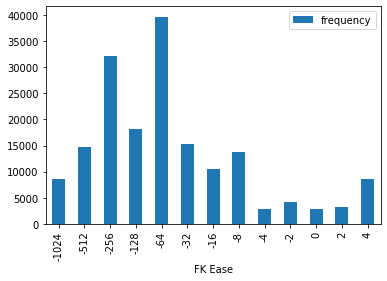

In [7]:
# Plots fk ease, and saves the plot
fk_ease_sizes, fk_ease_counts = gaming_df.select("fk_ease").rdd.flatMap(lambda x: x).histogram([-1024, -512, -256, -128, -64, -32, -16, -8, -4, -2, 0, 2, 4, 8])

pd_fk_ease = pd.DataFrame(
    list(zip(fk_ease_sizes, fk_ease_counts)), 
    columns=['FK Ease', 'frequency']
).set_index('FK Ease')
fig = pd_fk_ease.plot(kind='bar').get_figure()
fig.savefig('fk_ease', dpi=300)

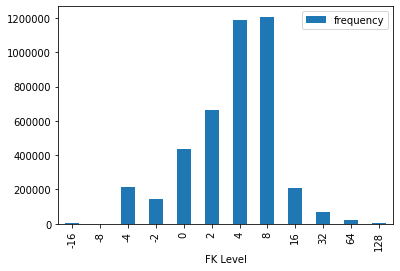

In [8]:
# Plots fk level, and saves the plot
fk_level_sizes, fk_level_counts = gaming_df.select("fk_level").rdd.flatMap(lambda x: x).histogram([-16,-8,-4,-2,0,2,4,8,16,32,64,128,258])

pd_fk_level = pd.DataFrame(
    list(zip(fk_level_sizes, fk_level_counts)), 
    columns=['FK Level', 'frequency']
).set_index('FK Level')
fig = pd_fk_level.plot(kind='bar').get_figure()
fig.savefig('fk_level', dpi=300)

## Distribution plot
The above graphs show the distribution of Gunning Fog Index and Flesch-Kincaid Readability Reading Ease and Grade Level, for the gaming subreddit

In [12]:
videos_df = df.filter("subreddit = 'videos'")
movies_df = df.filter("subreddit = 'movies'")

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# now compare two subreddits (videos and movies) and graph compare them in a graph
videos_sizes, videos_counts = videos_df.select("gf_index").rdd.flatMap(lambda x: x).histogram([2,4,8,16,32,64,128,258])
movies_sizes, movies_counts = movies_df.select("gf_index").rdd.flatMap(lambda x: x).histogram([2,4,8,16,32,64,128,258])

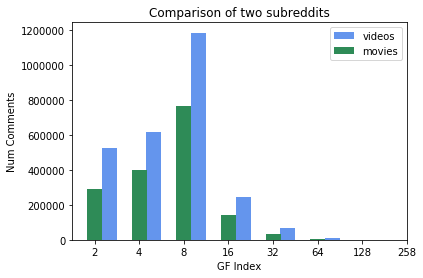

In [14]:
#makes the actual graph
N = len(videos_counts)
ind = np.arange(N)
width = 1

fig, ax = plt.subplots()
ax.bar(ind+0.33, videos_counts, width/3, color='cornflowerblue',label='videos')
ax.bar(ind, movies_counts, width/3, color='seagreen',label='movies')

ax.legend(loc="upper right")
ax.set_ylabel('Num Comments')
ax.set_xlabel('GF Index')
ax.set_title('Comparison of two subreddits')
ax.set_xticks(np.arange(N+1))
ax.set_xticklabels(videos_sizes)
fig.savefig('subreddit_comparison', dpi=300)

## Comparison of two subreddits

In the above figure, we compare to subreddits (videos and movies) to look at the difference in the Gunning Fog Index between the two. We observed that the gf index for the two is relatively similar, however the number of total comments for rideos is higher than the number of comments for movies. This was a challenge we faced in finding two similar subreddits, so that one did not completely drown out the other.